In [1]:
def stratify(x, y):
    
    import collections as col
    counts = col.Counter(y)
    n_max = np.max(counts.values())
    
    y_uniq = np.unique(y)
    y_out_class = [[] for i in range(y_uniq.size)]
    x_out_class = [[] for i in range(y_uniq.size)]
    for (i,y_u) in enumerate(y_uniq):
        inds = y==y_u
        y_class = y[inds]
        x_class = x[inds,:]
        inds = np.random.choice(np.arange(0,y_class.size), n_max, replace=True)
        y_out_class[i] = y_class[inds]
        x_out_class[i] = x_class[inds]
        
    y = np.concatenate(y_out_class)
    x = np.concatenate(x_out_class, axis=0)
    
    return x,y
        

In [15]:
import os
import pickle
import numpy as np
import xgboost as xgb
import pandas as pd

# from sklearn.preprocessing import OneHotEncoder
# from sklearn import preprocessing

feature_label = np.array(['light mean','light std','light off','light zcrossing','light skew','light kurt',\
                          'audio mean','audio std','audio skew','audio kurt','audio frq mean','audio frq std','audio frq skew','audio frq kurt',\
                          'screen frq mean','screen dur mean','screen dur std',\
                          'still','tilting','walking','unknown act', 'still-walking','still-tilting','still-unknown','walking-unknown',\
                          'messaging app','facebook app','chrome app','mobilyze app','phone app','gmail app','contacts app','internet app',\
                          'gallery app','email app','settings app',\
                          'messenger app','camera app','clock app','maps app','calendar app','youtube app','calculator app',\
                          'purple robot app','system ui app',\
                          'n call in','n call out','n sms in','n sms out','n missed',\
                          'n wifi',\
                          'latitude mean','longitude mean','location var',\
                          'temperature','dew point','weather',\
                          'visit duration','visit midtime','weekday start','weekday end',\
                          '4square cat 1','4square cat 2','4square cat 3','4square cat 4','4square cat 5','4square cat 6','4square cat 7',\
                          '4square cat 8','4square distance',\
                         'visit frequency','visit interval mean'])

n_bootstrap = 10
do_stratify = False

ft_dir = 'features_long/'

# list feature files
files = os.listdir(ft_dir)

with open('top_locations.dat') as f:
    state_top10 = pickle.load(f)
f.close()
for (i,s) in enumerate(state_top10):
    state_top10[i] = state_top10[i].replace('"','')
    state_top10[i] = state_top10[i].replace('[','')
    state_top10[i] = state_top10[i].replace(']','')

feature_all = []
state_all = []
state_fsq_all = []
for filename in files:
    with open(ft_dir+filename) as f:  
        feature, state = pickle.load(f)
        
        # only keeping top 10 states
        ind = np.array([], int)
        for (i,st) in enumerate(state['location']):
            if st in state_top10:
                ind = np.append(ind, i)
        feature = feature.loc[ind,:]
        state = state.loc[ind,'location']
        
        feature_all.append(feature)
        state_all.append(state)
        
    f.close()

x_train = pd.concat(feature_all, axis=0)
y_train = pd.concat(state_all)

if do_stratify:
    x_train, y_train = stratify(x_train,y_train)

gbm = [[] for _ in range(n_bootstrap)]
for sd in range(n_bootstrap):
    print 'bootstrap {}'.format(sd)
    gbm[sd] = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.05, nthread=12, subsample=1,\
                               max_delta_step=0, seed=sd).fit(x_train, y_train)


bootstrap 0
bootstrap 1
bootstrap 2
bootstrap 3
bootstrap 4
bootstrap 5
bootstrap 6
bootstrap 7
bootstrap 8
bootstrap 9


In [13]:
state_top10

['Shop or Store',
 'Home',
 'Food (Restaurant, Cafe)',
 "Another's Home",
 'Professional or Medical Office',
 'Work',
 'Arts & Entertainment (Theater, Music Venue, Etc.)',
 'Outdoors & Recreation',
 'Spiritual (Church, Temple, Etc.)',
 'Nightlife Spot (Bar, Club)']

(-1, 0)

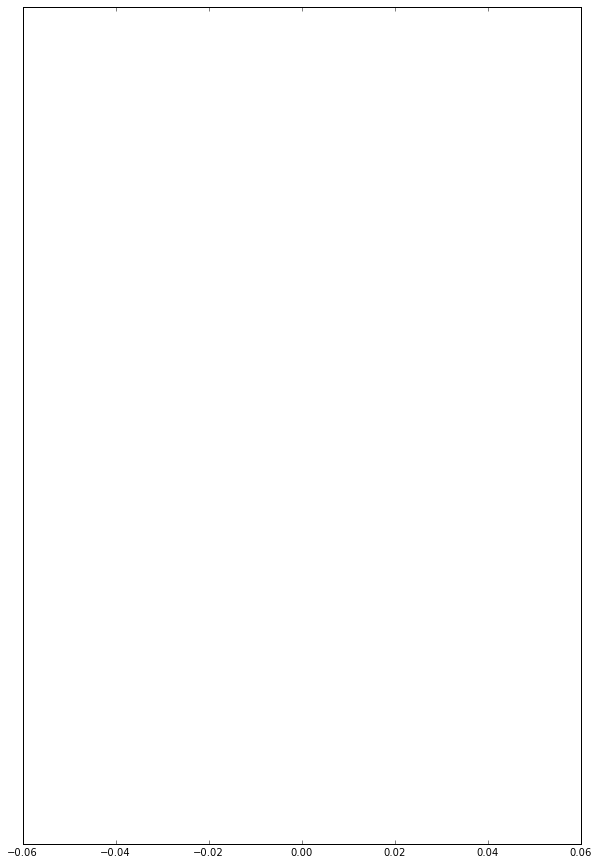

In [37]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.figure(figsize=(10,15))
axes = plt.gca()
#xgb.plot_importance(gbm, ax=axes, label=feature_label)

fscore = pd.DataFrame()
for i in range(n_bootstrap):
    fscore.loc[i,:] = np.array(gbm[i].booster().get_fscore().values())
fscore_mean = np.array(np.mean(fscore,axis=0))
ind_sort = np.argsort(fscore_mean)
val_sorted = fscore_mean[ind_sort]
key_sorted = list(np.array(gbm[0].booster().get_fscore().keys())[ind_sort])
plt.barh(np.arange(val_sorted.size), val_sorted, .7, color=(.4,.4,1), align='center')
plt.yticks(np.arange(len(key_sorted)), key_sorted, fontsize=12, color=(0,0,0));
axes.set_ylim([-1, len(key_sorted)])

In [35]:
np.array(gbm[i].booster().get_fscore().values())

array([ 304,  265,  295,   42,  463,  191,  180,  628, 1013,   44,  414,
        194,  108,   59,  115,  209,  259,  429,   31,   65,  145, 1426,
          4, 1181,  227,   10,  153,   33,    2,   84,   27,  172,    8,
        181,   47,  541,  151,  219,  340,  105,   58,  109,  163,  123,
         11,  391,  459,   21,  892,  138, 1682,  161, 1823,   28,   85,
       1641,  183,  245,  204,   55,  163,   75,   18, 1123])